In [2]:
from sklearn.preprocessing import LabelBinarizer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import KernelPCA
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

np.random.seed(42)

In [3]:
def encontrar_clusters(df,n_k):
  wcss = []

  for i in range(1,11):
      kmeans = KMeans(n_clusters = i, max_iter = 500, random_state=42)
      kmeans.fit(df) ## Se aplica K-Means a la base de datos 
      wcss.append(kmeans.inertia_)

  plt.plot(range(1,11), wcss)
  plt.title("Codo de Jambú")
  plt.xlabel('Número de Clusters')
  plt.ylabel('WCSS')
  plt.show()

  clustering = KMeans(algorithm='auto', copy_x = True, init='k-means++', n_clusters = n_k, max_iter = 300, random_state=42)
  clustering.fit(df)

  cluster_labels = clustering.labels_ + 1 
  df['KMeans_Clusters'] = cluster_labels

  centroids = clustering.cluster_centers_
  cen_x = [i[0] for i in centroids] 
  cen_y = [i[1] for i in centroids]

#-----------------------------------
  fig, (ax1, ax2) = plt.subplots(1, 2)
  fig.set_size_inches(18, 7)

  silhouette_avg = silhouette_score(df, cluster_labels)
  print("For n_clusters =", n_k,
         "The average silhouette_score is :", silhouette_avg)

  # Compute the silhouette scores for each sample
  sample_silhouette_values = silhouette_samples(df, cluster_labels)

  y_lower = 10
  for i in range(1,n_k+1):
      # Aggregate the silhouette scores for samples belonging to
      # cluster i, and sort them
      ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

      ith_cluster_silhouette_values.sort()

      size_cluster_i = ith_cluster_silhouette_values.shape[0]
      y_upper = y_lower + size_cluster_i

      color = cm.nipy_spectral(float(i) / n_k)
      ax1.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)

      # Label the silhouette plots with their cluster numbers at the middle
      ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

      # Compute the new y_lower for next plot
      y_lower = y_upper + 10  # 10 for the 0 samples

  ax1.set_title("The silhouette plot for the various clusters.")
  ax1.set_xlabel("The silhouette coefficient values")
  ax1.set_ylabel("Cluster label")

  # The vertical line for average silhouette score of all the values
  ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

  ax1.set_yticks([])  # Clear the yaxis labels / ticks
  ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

  # 2nd Plot showing the actual clusters formed

#  n_colores = len(pca_dff_df['KMeans_Clusters'].unique()) +1 
#  colores = ["blue","green","orange","yellow","red","black","pink","purple"][:n_colores]
#  fig = plt.figure(figsize = (6,6))

#  ax = fig.add_subplot(1,1,1)
#  ax.set_xlabel('Componente 1', fontsize = 15)
#  ax.set_ylabel('Componente 2', fontsize = 15)
#  ax.set_title('Componentes Principales', fontsize =20)

#  color_theme = np.array(colores)
#  ax.scatter(x = pca_dff_df.iloc[:,0], y = pca_dff_df.iloc[:,1],
#            c = color_theme[pca_dff_df.KMeans_Clusters], s =50)
  
#  plt.scatter(centroides[0],centroides[1], marker='^', s=90)

#  plt.show()


  colors = cm.nipy_spectral(cluster_labels.astype(float) / n_k)
  ax2.scatter(x = df.iloc[:,0], y = df.iloc[:,1], marker='.', s=30, lw=0, alpha=0.7,
              c=colors, edgecolor='k')

  # Labeling the clusters
  centers = clustering.cluster_centers_
  # Draw white circles at cluster centers
  ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
              c="white", alpha=1, s=200, edgecolor='k')

  for i, c in enumerate(centers):
      sub_i = int(i) + 1
      ax2.scatter(c[0], c[1], marker='$%d$' % sub_i, alpha=1,
                  s=50, edgecolor='k')

  ax2.set_title("The visualization of the clustered data.")
  ax2.set_xlabel("Feature space for the 1st feature")
  ax2.set_ylabel("Feature space for the 2nd feature")

  plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                "with n_clusters = %d" % n_k),
                fontsize=14, fontweight='bold')

  plt.show()


#-----------------------------------
  

#  respuesta = {
#      "df" : df,
#      "centroides": [cen_x, cen_y]
#  }

  return df

In [4]:
def union_clusters(df, dff):
  prueba = df.join(dff)
  print(prueba.count())
  print(prueba.value_counts(["KMeans_Clusters"]))
  return prueba

In [5]:
def normalizar(df):
  df_index = df.index
  df_columns = df.columns
  x = df.values #returns a numpy array
  StandardScaler = preprocessing.StandardScaler()
  x_scaled = StandardScaler.fit_transform(x)
  dff = pd.DataFrame(x_scaled).set_index(df_index)
  dff.columns = df_columns
  return dff

In [6]:
def calcular_componentes(df, n_componentes):
  kpca = KernelPCA(n_components=n_componentes, random_state=40)
  pca_dff = kpca.fit_transform(df)
  pca_dff_df = pd.DataFrame(data = pca_dff, index = df.index)
  print(kpca.lambdas_)
  print(kpca.alphas_)
  explained_variance = np.var(pca_dff, axis=0)
  explained_variance_ratio = explained_variance / np.sum(explained_variance)
  print(explained_variance)
  print(explained_variance_ratio)

  return pca_dff_df

In [7]:
def nubank_categorical_preprocessing(nu_cat):
    '''Transforms a categorical column into One-Hot Encoding (OHE)
    
    Parameters
    -----------
    nu_cat: array, shape = (-1, 1)
        Categorical column to encode.

    Returns
    -----------
    nu_cat_ohe : array, shape = (-1, 1)
        One-hot encoded categorical column

    '''
    encoder = LabelBinarizer()
    nu_cat_ohe = encoder.fit_transform(nu_cat)

    ohes = encoder.transform(encoder.classes_.reshape(-1, 1))
    for category, ohe in zip(encoder.classes_, ohes):
        print("{:>10} -> {}".format(category, ohe))
        pass

    ###########################################################################
    # For Scikit-Learn > 0.19.2:
    #     Class "OneHotEncoder" is preferred over "LabelBinarizer", and the
    #     attribute to use is "categories_" not "classes_"
    ###########################################################################

    return nu_cat_ohe

In [10]:
ruta_archivo = 'DBFinal.xlsx'
df = pd.read_excel(ruta_archivo,sheet_name="Datos (3)")

FileNotFoundError: [Errno 2] No such file or directory: 'DBFinal.xlsx'

In [961]:
variables_categoricas = df.columns.values.tolist()
print(variables_categoricas,type(variables_categoricas))
del variables_categoricas[0:2]
print(variables_categoricas,type(variables_categoricas))

# "F48_TRADICIONAL","F17_PEQUEÑOS","F15_INTERNOS", "F15_EXTERNOS",
variables_numericas = ["F48_DIGITAL", "F48_TARJETAS", "F48_TRADICIONAL",
                 "F22_MUERTE", "F22_FRACASO", "F22_PERDIDA", "F22_LIMITARME",
                  "F17_MEDIANOS", "F17_GRANDES",
                  "INGRESO_PERSONAL_REC"]

In [ ]:
variables_numericas = []

In [962]:
nu_categorical = df[variables_categoricas]
nu_numerical = df[variables_numericas]
nu_numerical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3002 entries, 0 to 3001
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   F48_DIGITAL           3002 non-null   int64  
 1   F48_TARJETAS          3002 non-null   int64  
 2   F48_TRADICIONAL       3002 non-null   int64  
 3   F22_MUERTE            3002 non-null   int64  
 4   F22_FRACASO           3002 non-null   int64  
 5   F22_PERDIDA           3002 non-null   int64  
 6   F22_LIMITARME         3002 non-null   int64  
 7   F17_MEDIANOS          3002 non-null   int64  
 8   F17_GRANDES           3002 non-null   int64  
 9   INGRESO_PERSONAL_REC  3002 non-null   float64
dtypes: float64(1), int64(9)
memory usage: 234.7 KB


In [963]:
def avoid_cast_error(nu_cat):
    nu_cat = df[variables_categoricas]
    ndf = pd.DataFrame()
    for col in nu_cat.columns:
        n = []
        print(col)
        # print(nu_cat[col].dtypes)
        for v in nu_cat[col]:
            n.append(str(v))
        ndf= pd.concat([ndf, pd.Series(n)], ignore_index=True, axis=1)
        # print()
    nu_cat = ndf.rename(dict(zip([x for x in range(len(nu_cat.columns))],nu_cat.columns)) ,axis=1)
    return nu_cat
nu_categorical = avoid_cast_error(nu_categorical)

NSE_REC
F5_ESTADOCIVIL_REC
rangos
GENERO
AREAS
F7
F24
F37
F44
F46
F47
F62
F63
F66
F67
F75


In [964]:
def nu_ohe(nu_cat):
    ndf = pd.DataFrame()
    n = []
    # names = {}
    for col in nu_cat.columns:
        resulting_cols = nubank_categorical_preprocessing(nu_cat[col])
        ndf = pd.concat([ndf, pd.DataFrame(resulting_cols)], axis=1, ignore_index=True)
        # names[col] = ['{}_{}'.format(col, x) for x in range(1, resulting_cols.shape[1])]
        n += ['{}_{}'.format(col, x) for x in range(1, resulting_cols.shape[1]+1)]
        print(col)
        print()
    nu_cat_ohe = ndf.rename( columns= dict(zip([x for x in range(0, len(ndf.columns) + 1)], n)))
    return nu_cat_ohe
nu_cat_ohe = nu_ohe(nu_categorical)

      ABC+ -> [1 0 0]
         C -> [0 1 0]
      C-D+ -> [0 0 1]
NSE_REC

CASADO_UNIONLIBRE -> [1 0 0]
COMPROMETIDO_RELACIONCOMPLICADA -> [0 1 0]
VIUDOS_SEPARADOS_SOLTEROS_DIVORCIADOS -> [0 0 1]
F5_ESTADOCIVIL_REC

   16 - 25 -> [1 0 0 0]
   26 - 35 -> [0 1 0 0]
   36 - 45 -> [0 0 1 0]
   46 - 55 -> [0 0 0 1]
rangos

    Hombre -> [0]
     Mujer -> [1]
GENERO

ÁREA I - PACIFICO -> [1 0 0 0 0 0]
ÁREA II - NORTE -> [0 1 0 0 0 0]
ÁREA IV - CENTRO -> [0 0 1 0 0 0]
ÁREA V - VALLE DE MEXICO -> [0 0 0 1 0 0]
ÁREA VI - SURESTE -> [0 0 0 0 1 0]
Área III - BAJIO -> [0 0 0 0 0 1]
AREAS

Empleado de medio tiempo -> [1 0 0 0 0 0 0 0 0 0 0 0 0]
Empleado y además tengo un negocio propio aparte -> [0 1 0 0 0 0 0 0 0 0 0 0 0]
Empleado/a de tiempo completo -> [0 0 1 0 0 0 0 0 0 0 0 0 0]
Empresario/a - Soy propietario/a, accionista o socio/a de uno o varios negocios -> [0 0 0 1 0 0 0 0 0 0 0 0 0]
Estudiante a tiempo completo -> [0 0 0 0 1 0 0 0 0 0 0 0 0]
Estudiante y tengo un trabajo de tiempo completo

In [965]:
nu_complete = pd.concat([nu_cat_ohe, nu_numerical], axis=1)

--------------------
--------------------
# 7 clusters sin locus
--------------------

In [966]:
dff = normalizar(nu_complete)

In [967]:
pca_dff_df = calcular_componentes(dff, 2) # componentes

[13262.11639296 10784.58083831]
[[ 0.02407575 -0.01218665]
 [ 0.02085742  0.02149807]
 [-0.0169205   0.01625527]
 ...
 [-0.0236714  -0.01179367]
 [-0.01172441  0.02307076]
 [-0.02010312  0.02605257]]
[4.41776029 3.5924653 ]
[0.55151509 0.44848491]


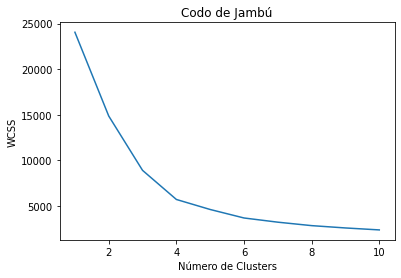

For n_clusters = 7 The average silhouette_score is : 0.5941345204012117


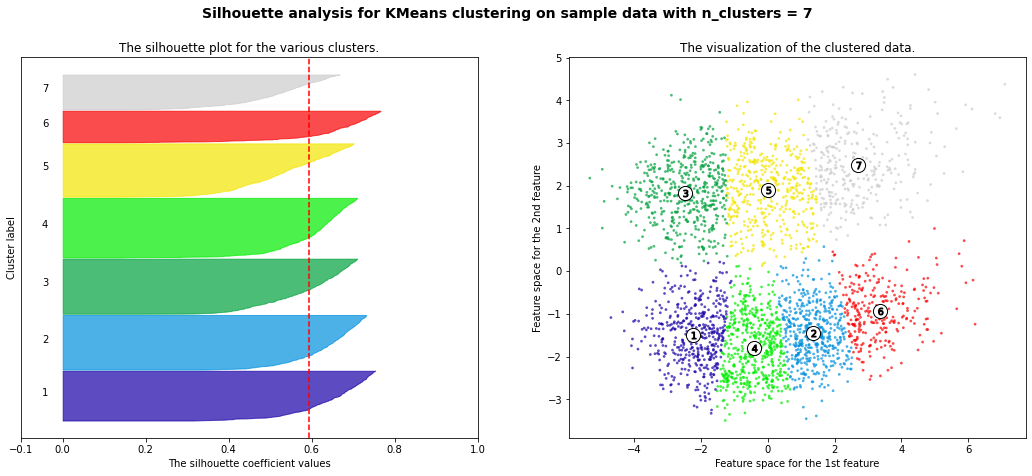

In [968]:
respuesta_clusters = encontrar_clusters(pca_dff_df, 7) # clusters 
# dejar locus

In [969]:
pca_dff_df = respuesta_clusters

In [970]:
prueba = union_clusters(nu_complete, pca_dff_df) # unir

NSE_REC_1               3002
NSE_REC_2               3002
NSE_REC_3               3002
F5_ESTADOCIVIL_REC_1    3002
F5_ESTADOCIVIL_REC_2    3002
                        ... 
F17_GRANDES             3002
INGRESO_PERSONAL_REC    3002
0                       3002
1                       3002
KMeans_Clusters         3002
Length: 105, dtype: int64
KMeans_Clusters
4                  528
3                  488
2                  484
5                  472
1                  441
7                  310
6                  279
dtype: int64


In [971]:
lista_tablas = []
for c in columnas:
  if c in columnas_promedio:
    tabla = prueba[[c,"KMeans_Clusters"]].groupby("KMeans_Clusters").mean().transpose()
  else:
    tabla = pd.crosstab(prueba[c],prueba["KMeans_Clusters"])
  tabla.index = [f'{c}|{x}' for x in tabla.index]
  lista_tablas.append(tabla)

pd.concat(lista_tablas, axis=0).to_excel("resultados_7clusters.xlsx")
prueba.to_excel("pruebas_7.xlsx")

--------------------
--------------------
# 8 cluster con locus
--------------------

In [972]:
ruta_archivo = 'C:\\Users\\nomad\\Documents\\work\\aleph\\nu\\data\\coded_database.xlsx'

# f17_colnames = ["F17_O{}_REC".format(x) for x in range(1, 18)]
# f48_colnames = ["F48_O{}_REC".format(x) for x in range(1, 18)]
# f31_colnames = ['F31_O{}_REC'.format(x) for x in range(1,6)]
# f32_colnames = ["T_F32_{}_REC".format(x) for x in range(1, 21)]

# "F9_TIPO_FAMILI_REC", 'F8', 'F16', 'F23', 'F34', 'F56','F57','F60', 'F61','F45','F63','F67','F76','F81','F87',
variables_categoricas = ["NSE_REC",
                 "F5_ESTADOCIVIL_REC",
                 'rangos',
                 'GENERO',
                 'AREAS',
                 'F7',
                 'F24',         
                 'F37',
                 'F44',
                 'F46',
                 'F47',                
                 'F62',
                 'F63',
                 'F66',
                 'F67',
                 'F75',
                 ]

# "F48_TRADICIONAL","F17_PEQUEÑOS","F15_INTERNOS", "F15_EXTERNOS",
variables_numericas = ["F48_DIGITAL", "F48_TARJETAS", "F48_TRADICIONAL",
                 "F22_MUERTE", "F22_FRACASO", "F22_PERDIDA", "F22_LIMITARME",
                  "F17_MEDIANOS", "F17_GRANDES","F15_INTERNOS", "F15_EXTERNOS",
                  "INGRESO_PERSONAL_REC"]

In [973]:
dff = normalizar(nu_complete)

In [974]:
pca_dff_df = calcular_componentes(dff, 2) # componentes

[13262.11639296 10784.58083831]
[[ 0.02407575 -0.01218665]
 [ 0.02085742  0.02149807]
 [-0.0169205   0.01625527]
 ...
 [-0.0236714  -0.01179367]
 [-0.01172441  0.02307076]
 [-0.02010312  0.02605257]]
[4.41776029 3.5924653 ]
[0.55151509 0.44848491]


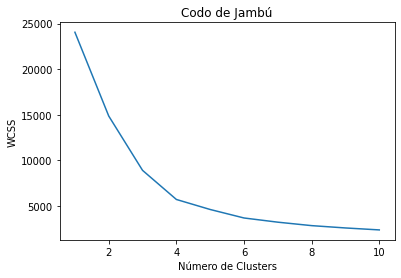

For n_clusters = 8 The average silhouette_score is : 0.6068018897366464


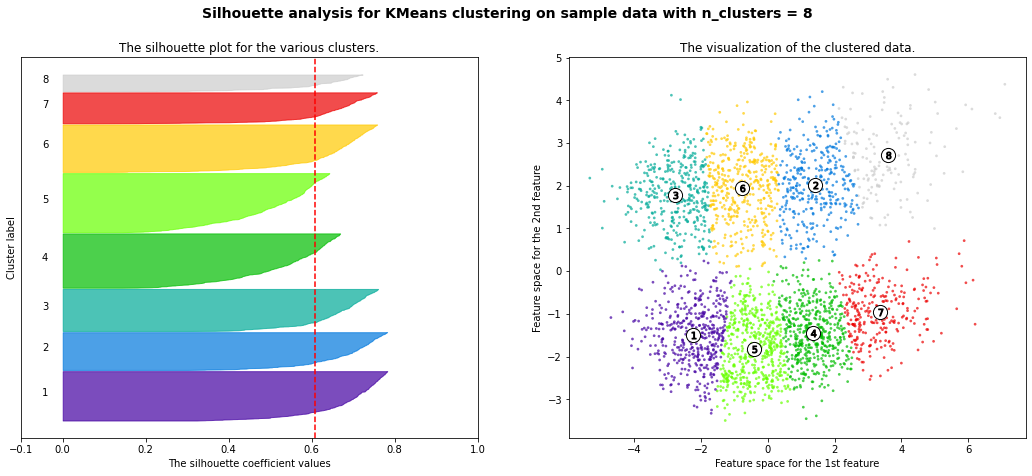

In [975]:
respuesta_clusters = encontrar_clusters(pca_dff_df, 8) # clusters
# quitar locus

In [976]:
pca_dff_df = respuesta_clusters

In [977]:
prueba = union_clusters(nu_complete, pca_dff_df) # unir

NSE_REC_1               3002
NSE_REC_2               3002
NSE_REC_3               3002
F5_ESTADOCIVIL_REC_1    3002
F5_ESTADOCIVIL_REC_2    3002
                        ... 
F17_GRANDES             3002
INGRESO_PERSONAL_REC    3002
0                       3002
1                       3002
KMeans_Clusters         3002
Length: 105, dtype: int64
KMeans_Clusters
5                  525
4                  483
1                  439
6                  422
3                  374
2                  336
7                  275
8                  148
dtype: int64


In [978]:
columnas = nu_complete.columns

In [979]:
columnas_promedio = []

In [980]:
lista_tablas = []
for c in columnas:
  if c in columnas_promedio:
    tabla = prueba[[c,"KMeans_Clusters"]].groupby("KMeans_Clusters").mean().transpose()
  else:
    tabla = pd.crosstab(prueba[c],prueba["KMeans_Clusters"])
  tabla.index = [f'{c}|{x}' for x in tabla.index]
  lista_tablas.append(tabla)

pd.concat(lista_tablas, axis=0).to_excel("resultados_8clusters.xlsx")
prueba.to_excel("pruebas_df2.xlsx")

In [981]:
# pd.concat(lista_tablas, axis=0).to
# F48, F22, F17

